# Run VAE on rotated MNIST dataset

In [1]:
# Load libraries
import sys
sys.path.append('../models')
import os.path as osp
import yaml

import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from dm_mnist import MnistDataModule
import matplotlib.pyplot as plt
from vae import VAE
from spatialVAE import SpatialVAE
from pyroVAE import PyroVAE
from omegaconf import OmegaConf
from zz_plot_utils import *

# To ensure reproducibility
pl.seed_everything(123)

/Users/ckapoura/anaconda3/envs/vae/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
Global seed set to 123


123

# Load trained model and MNIST dataset

In [2]:
# Dataset modification
modify = 1 # rotate or none
z_dim = 2

# Dataset
dm = MnistDataModule(data_dir = osp.join('..', 'data'), dataset_name="MNIST", modify=1)
dm.setup()

# Pyro SpatialVAE model
base_dir = f'../output/PyroVAE_mnist_m{modify}_z{z_dim}/'
pyrovae = load_pyrovae(base_dir, data_dim = (1, 28, 28))
pyrovae = pyrovae.eval()

# SpatialVAE model
base_dir = f'../output/SpatialVAE_mnist_m{modify}_z{z_dim}/'
spvae = load_spvae(base_dir, data_dim = (1, 28, 28))
spvae = spvae.eval()

# VAE model
base_dir = f'../output/VAE_mnist_z{z_dim}/'
vae = load_vae(base_dir, data_dim = (1, 28, 28))
vae = vae.eval()

/Users/ckapoura/Research/Projects/yau/spatialDGM/code/spatialDGM/notebooks/../models/dm_mnist.py:272: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Latent space visualisation

### VAE

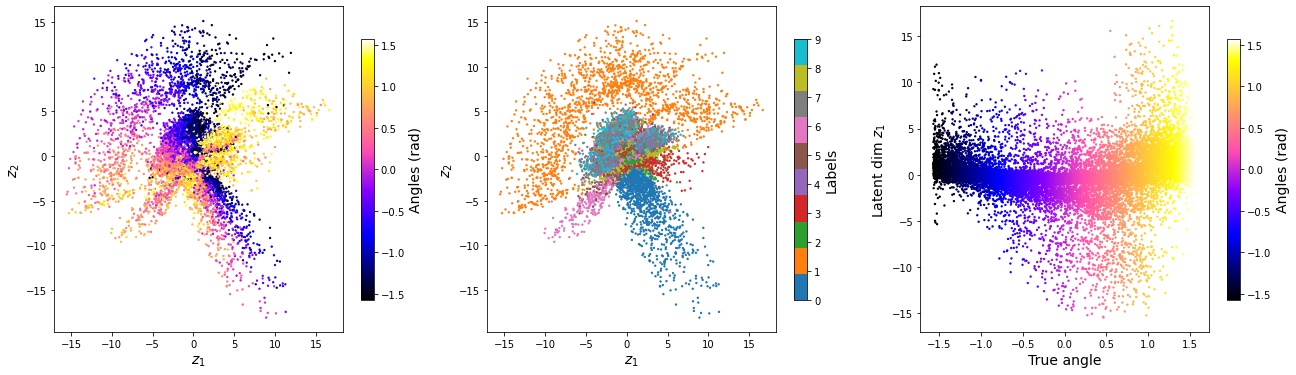

In [4]:
plot_latent(vae, dm.train_set, ax=None, z_dim=z_dim, num_batches=15000)

### Spatial VAE

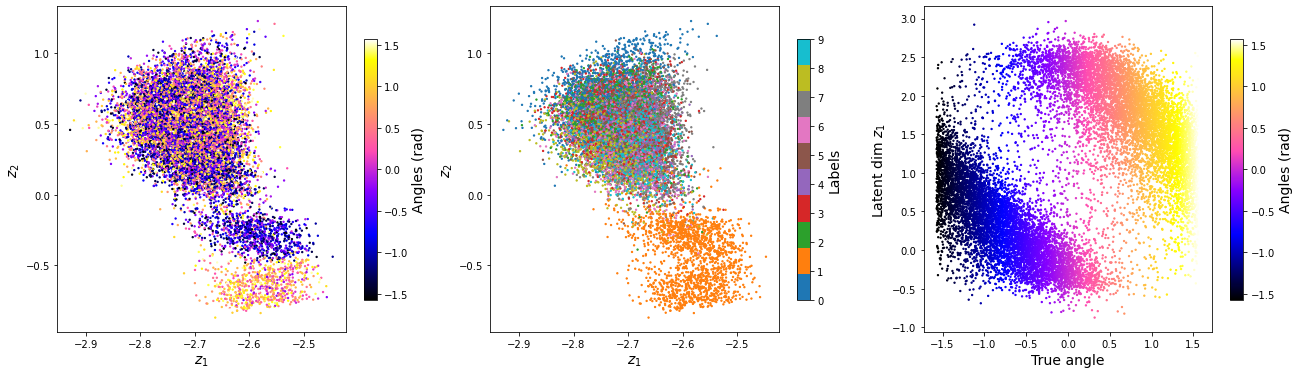

In [5]:
plot_latent(spvae, dm.train_set, ax=None, z_dim=z_dim, num_batches=15000)

### Pyro SpatialVAE

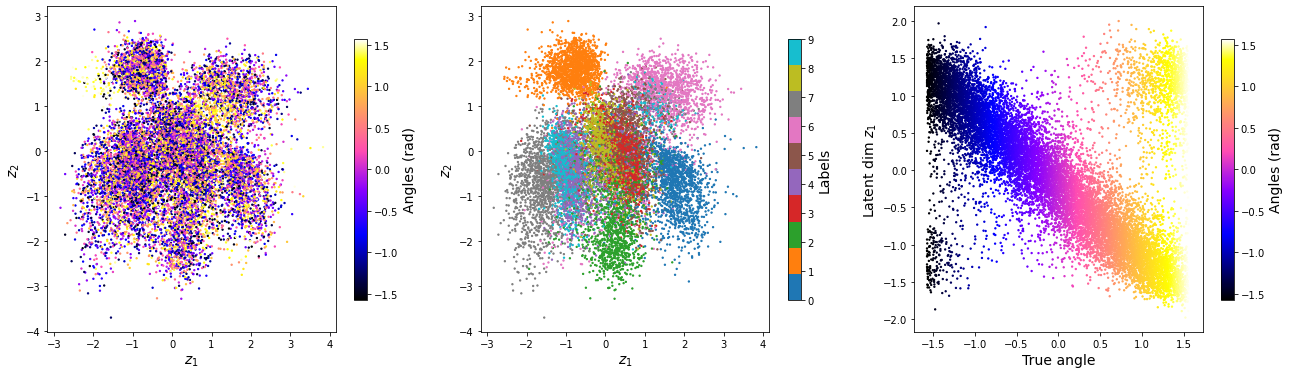

In [6]:
plot_latent(pyrovae, dm.train_set, ax=None, z_dim=z_dim, num_batches=15000)

In [4]:
#plt.rcParams['figure.figsize'] = [8, 7]    
#w, h = plt.rcParams.get('figure.figsize')
#fig, axs = plt.subplots(2, 2, figsize=(w * 2, h), facecolor='w')
#plot_latent(vae, dm.train_set, ax=axs[0], z_dim=z_dim, num_batches=15000)
#plot_latent(spvae, dm.train_set, ax=axs[1], z_dim=z_dim, num_batches=15000)
#axs[0].set_ylabel('VAE')
#axs[1].set_ylabel('spatialVAE')

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
#w, h = plt.rcParams.get('figure.figsize')
#fig, axs = plt.subplots(1, 3, figsize=(w, h), facecolor='w')
if (z_dim == 2):
    vae.manifold2d(d=25, cmap='viridis')
    spvae.manifold2d(d=25, cmap='viridis')
    pyrovae.manifold2d(d=25, cmap='viridis')

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

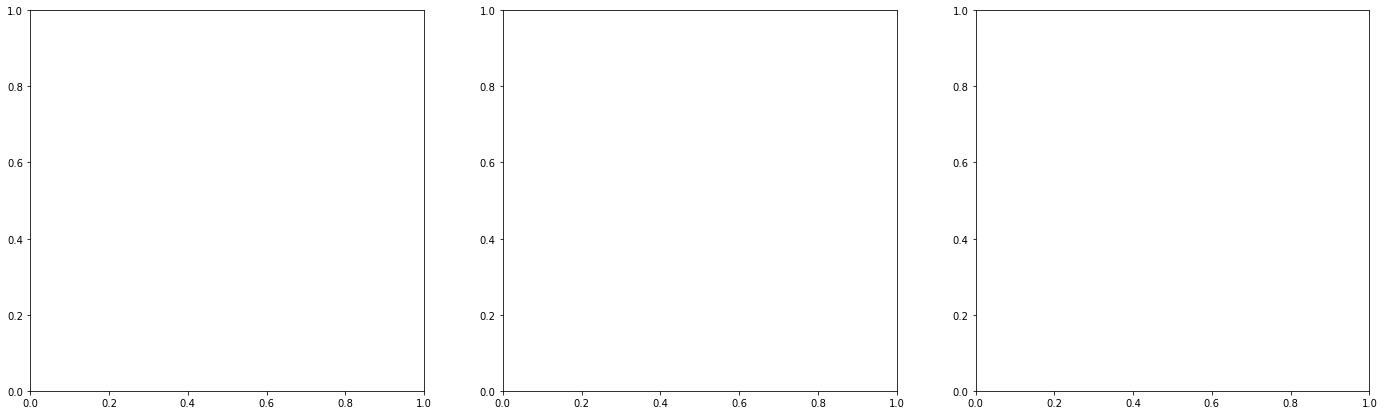

In [9]:
plt.rcParams['figure.figsize'] = [8, 7]
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(1, 3, figsize=(3*w, h), facecolor='w')
if (z_dim == 2):
    plot_reconstructed(vae, ax=axs, r0=(-14, 14), r1=(-14, 14))
    plot_reconstructed(spvae, ax=axs[0], r0=(-2.8, -2.5), r1=(-1, 1))
    plot_reconstructed(pyrovae, ax=axs[1], r0=(-2, 2.7), r1=(-2.5, 2))

## Interpolation

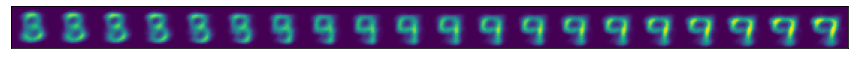

In [7]:
plt.rcParams['figure.figsize'] = [15, 20]
data = dm.train_dataloader()
x, y, k = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 0][1].to('cpu') # find a 1
x_2 = x[y == 6][1].to('cpu') # find a 0

interpolate(pyrovae, x_1, x_2, n=20)

# Model predictions

## Training data

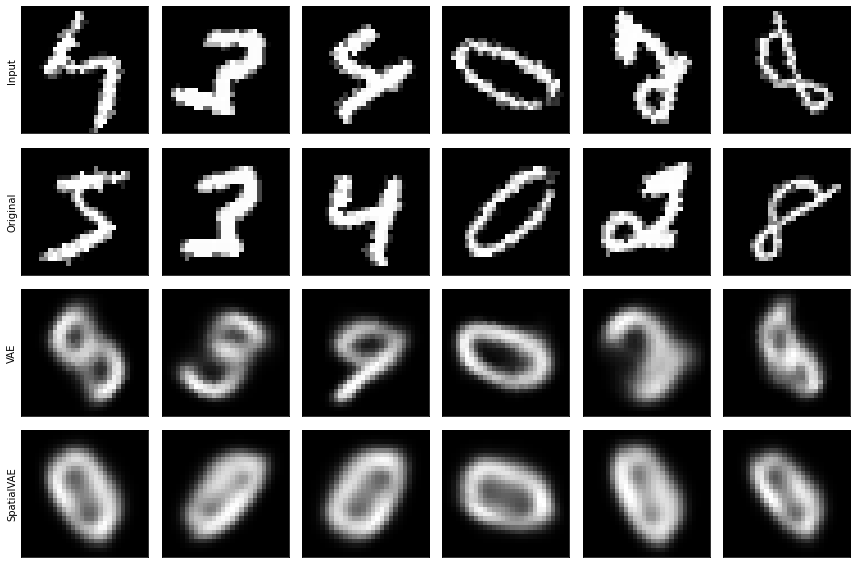

In [13]:
plt.rcParams['figure.figsize'] = [6, 4]
viz_num = 6
train_loader = dm.train_dataloader()
viz_idxs = np.linspace(0, len(train_loader.dataset) - 1, viz_num).astype(int)
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(4, len(viz_idxs), figsize=(w * 2, h * 2), facecolor='w')
                        
plot_predictions(dm_loader=train_loader, viz_idxs=viz_idxs, axs=axs, vae=vae, spvae=spvae, pyrovae=None)

## Test data

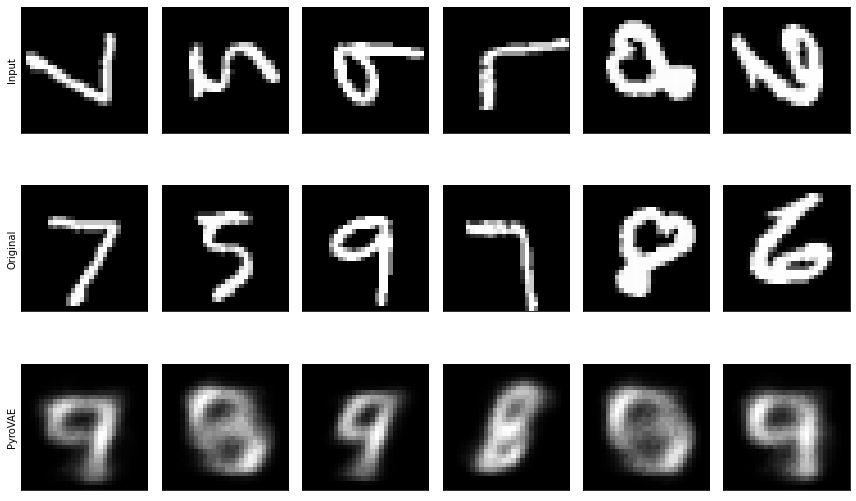

In [10]:
test_loader = dm.val_dataloader()
viz_idxs = np.linspace(0, len(test_loader.dataset) - 1, viz_num).astype(int)
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(3, len(viz_idxs), figsize=(w * 2, h * 2), facecolor='w')
                        
plot_predictions(dm_loader=test_loader, viz_idxs=viz_idxs, axs=axs, vae=None, spvae=None, pyrovae=pyrovae)